In [199]:
import os.path as op
import numpy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image, ImageSequence

def compute_aps_in_clip(clip_vars):
    count_actions_in_clip = 0
    for action in clip_vars['actions']:
        action_timeseries = [int(x) for x in clip_vars[action]]
        action_timeseries[0] = 0
        action_timeseries[-1] = 0
        action_timeseries_diff = np.diff(action_timeseries)
        for val in action_timeseries_diff:
            if val == 1:
                count_actions_in_clip += 1

    avg_aps_in_clip = count_actions_in_clip/(len(action_timeseries)/60)
    return avg_aps_in_clip

def compute_clip_duration(clip_vars):
    return len(clip_vars['A'])/60

clips_fpath = '/home/hyruuk/DATA/mario/pattern_clips/'
data_fpath = op.join(clips_fpath, 'clip_data.pkl')

with open(data_fpath, 'rb') as f:
    data = pickle.load(f)

In [139]:
clip_durations = []
clip_avg_aps = []
for clip_vars in data['clip_vars']:
    clip_durations.append(compute_clip_duration(clip_vars))
    clip_avg_aps.append(compute_aps_in_clip(clip_vars))

data['clip_durations'] = clip_durations
data['clip_avg_aps'] = clip_avg_aps


allsubj_dict = {'clip_duration': data['clip_durations'], 
             'clip_avg_aps': data['clip_avg_aps'], 
             'clip_code': data['clip_codes'], 
             'clip_scene': data['clip_scenes'],
             'subjects': data['subjects']}
allsubj_df = pd.DataFrame(allsubj_dict)


In [151]:
allsubj_indexed_list = []
for subj in allsubj_df['subjects'].unique():

    subj_plot_df = allsubj_df[allsubj_df['subjects'] == subj]
    subj_plot_df = subj_plot_df.sort_values(by='clip_code')
    subj_plot_df = subj_plot_df.reset_index(names='global_idx', drop=False)

    df_list = []
    for scene in subj_plot_df['clip_scene'].unique():
        scene_df = subj_plot_df[subj_plot_df['clip_scene'] == scene]
        scene_df = scene_df.reset_index(drop=True)
        scene_df = scene_df.sort_values(by='clip_code')
        scene_df = scene_df.reset_index(names='scene_idx', drop=False)
        df_list.append(scene_df)

    indexed_df = pd.concat(df_list).reset_index(drop=True)
    allsubj_indexed_list.append(indexed_df)
allsubj_indexed_list = pd.concat(allsubj_indexed_list).reset_index(drop=True)

allsubj_indexed_list.to_csv('/home/hyruuk/DATA/mario/pattern_clips/indexed_clip_data.csv', index=False)
allsubj_indexed_list

scene_idx  global_idx  clip_duration  clip_avg_aps       clip_code  \
0             0           0       7.600000      1.447368  00101000000122   
1             1          22       2.350000      0.851064  00101010000122   
2             2          42       2.166667      1.384615  00101020000122   
3             3          57       2.133333      1.875000  00101030000122   
4             4          72       1.933333      1.551724  00101040000122   
...         ...         ...            ...           ...             ...   
2295          4        2052      19.483333      1.539778  01002020006743   
2296          5        2180       3.416667      2.048780  01704030001184   
2297          6        2216       4.633333      2.589928  02103000001501   
2298          7        2231       3.800000      2.368421  02204060001591   
2299          8        2246       4.733333      1.478873  02304050004786   

     clip_scene subjects  
0             0   sub-01  
1             0   sub-01  
2             0   sub-01  
3             0   sub-01  
4             0   sub-01  
...         ...      ...  
2295         10   sub-06  
2296         10   sub-06  
2297         10   sub-06  
2298         10   sub-06  
2299         10   sub-06  

[2300 rows x 7 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

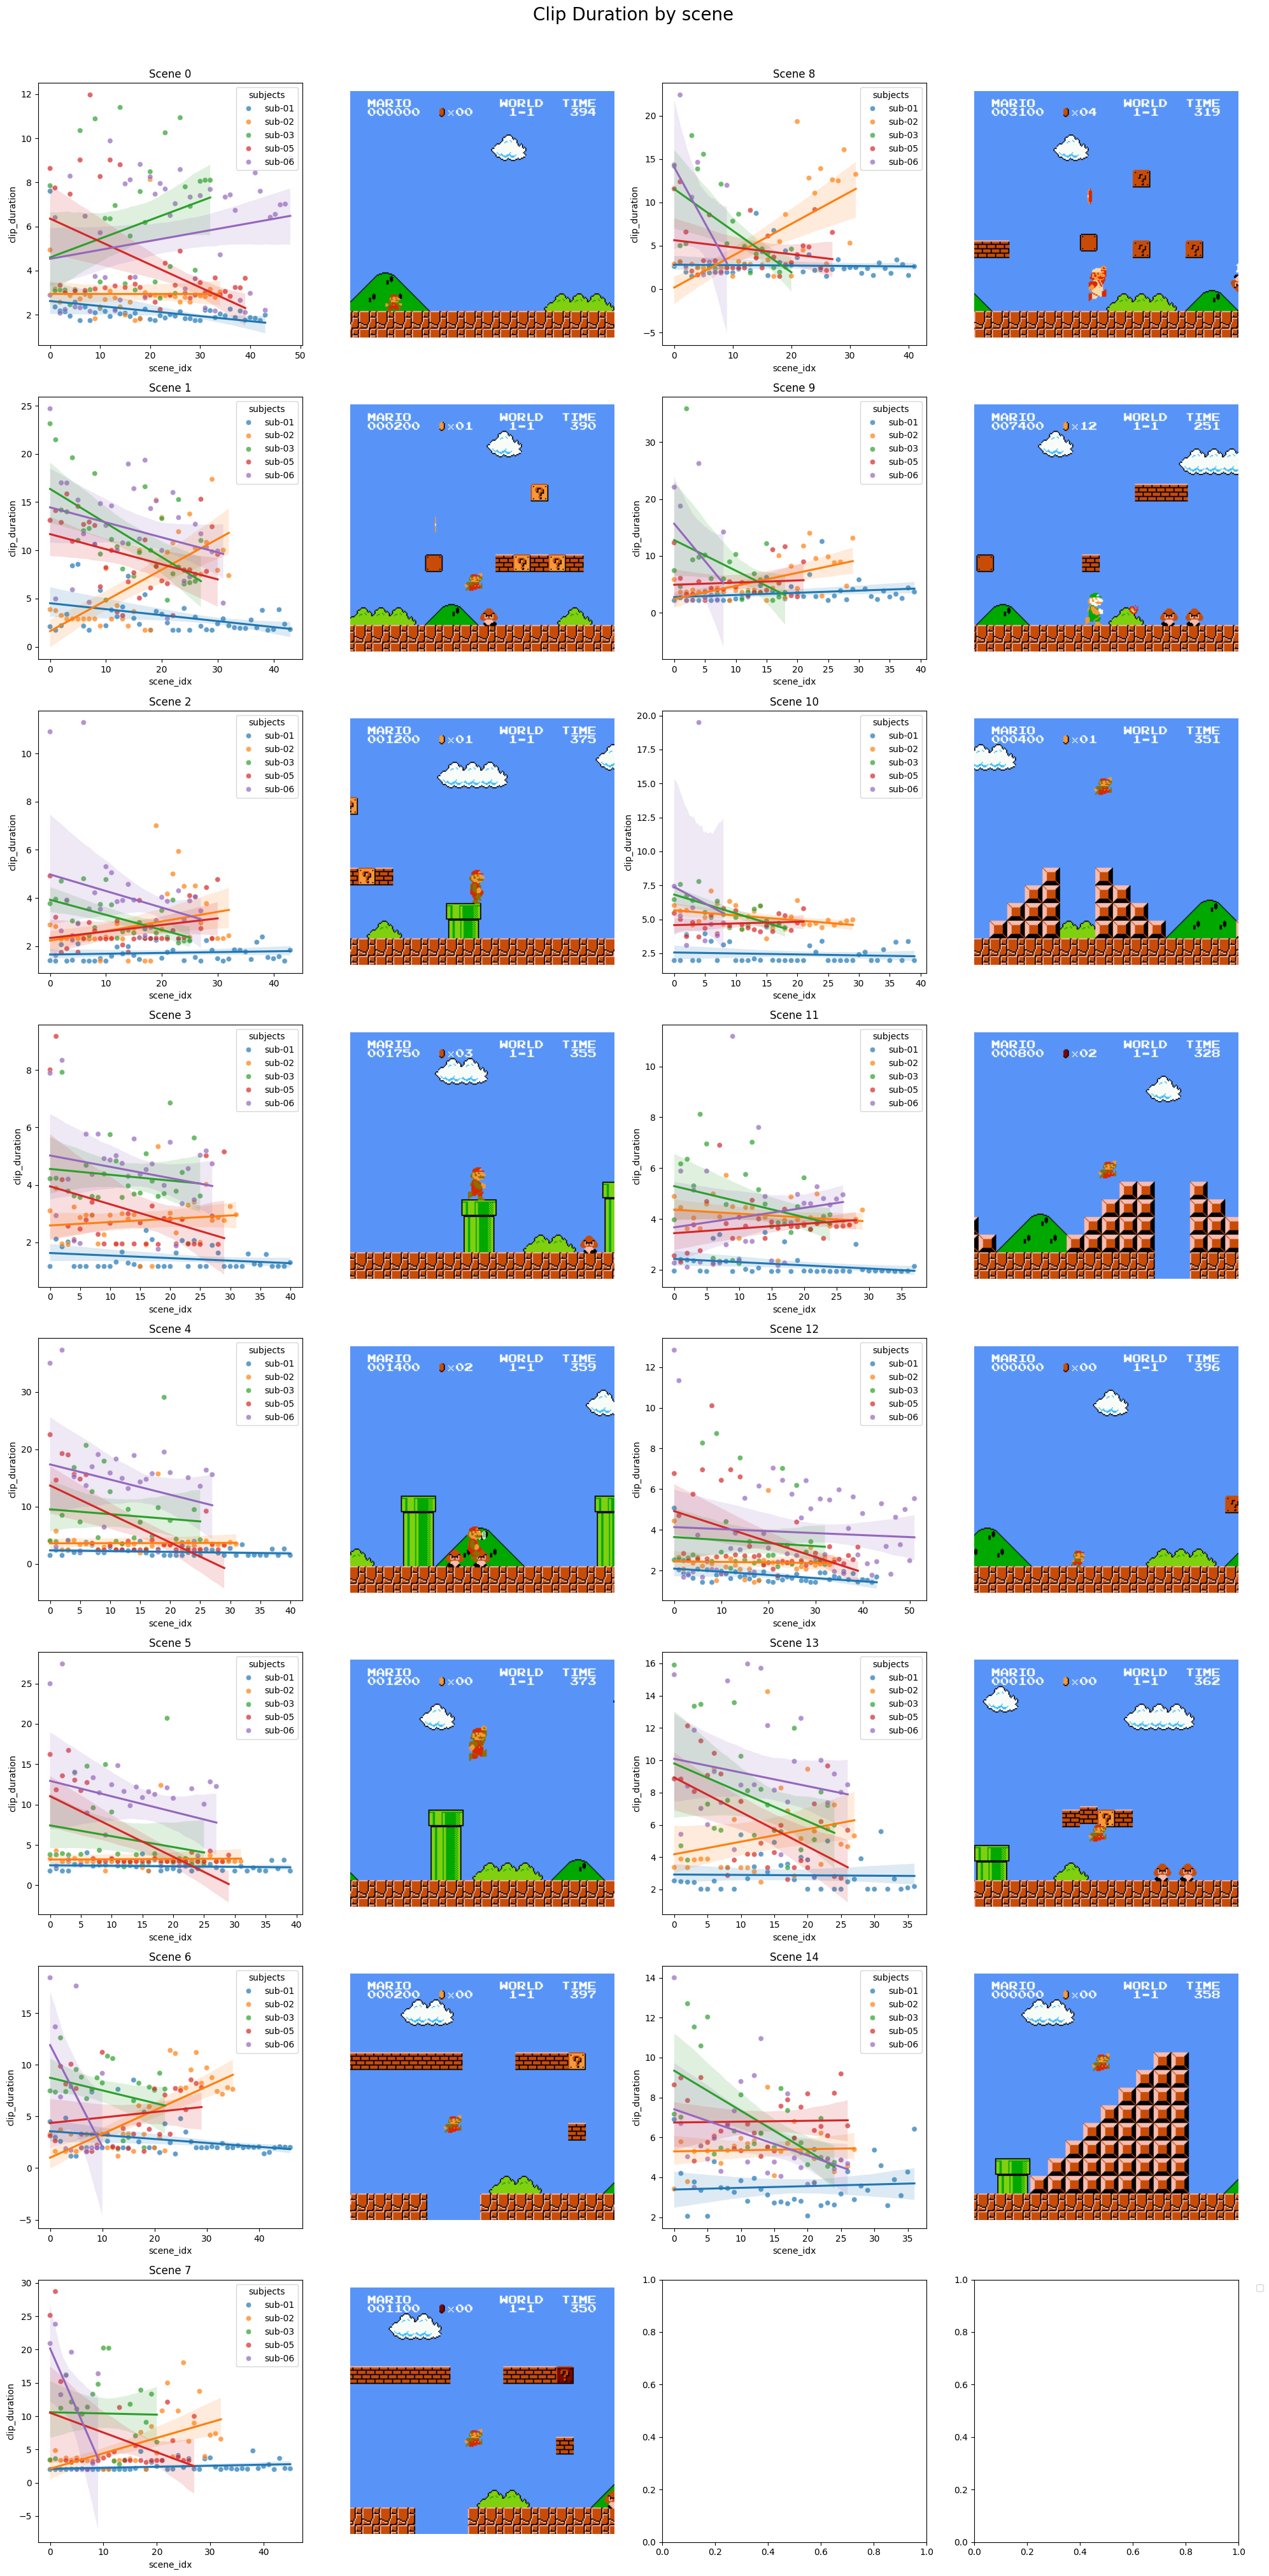

In [216]:
## Scene-wise analysis
performance_metric = 'clip_duration'
fig, axs = plt.subplots(8, 4, figsize=(20, 40))
scenes_list = sorted([int(x) for x in allsubj_indexed_list['clip_scene'].unique()])

# Find all gif files in clips_folder
gif_files = [f for f in os.listdir(clips_fpath) if f.endswith('.gif')]
scene_files = {}
for scene in scenes_list:
    for file in gif_files:
        file_scene = int(file.split('_')[4].split('-')[1])
        if file_scene == scene:
            scene_files[scene] = file
            break


# Plotting
for idx_scene, scene in enumerate(scenes_list):
    scene_x_idx = 0 if scene < len(scenes_list)/2 else 2
    frame_x_idx = scene_x_idx + 1
    # Plot curves
    ax = axs[idx_scene%8, scene_x_idx]
    scene_df = allsubj_indexed_list[allsubj_indexed_list['clip_scene'] == str(scene)]
    ax = sns.scatterplot(x='scene_idx', y=performance_metric, data=scene_df, hue='subjects', ax=ax, alpha=0.7)
    ax.set_title(f'Scene {str(scene)}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # Add a regression line for each subject, keeping the same color as the subject from the lineplot
    for idx_subj, subj in enumerate(scene_df['subjects'].unique()):
        subj_df = scene_df[scene_df['subjects'] == subj]
        sns.regplot(x='scene_idx', y=performance_metric, data=subj_df, ax=ax, scatter=False, color=ax.get_lines()[idx_subj].get_c())
    # Plot frame
    ax_frame = axs[idx_scene%8, frame_x_idx]
    scene_file_path = op.join(clips_fpath, scene_files[scene])
    im = Image.open(scene_file_path)
    frames = ImageSequence.Iterator(im)
    for _ in range(50):
        frame = next(frames)
    ax_frame.imshow(frame)
    # remove axis
    ax_frame.axis('off')

if performance_metric == 'clip_duration':
    title = 'Clip Duration by scene'
elif performance_metric == 'clip_avg_aps':
    title = 'Average Actions per Second by scene'
plt.suptitle(title, fontsize=20, y=1.01)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

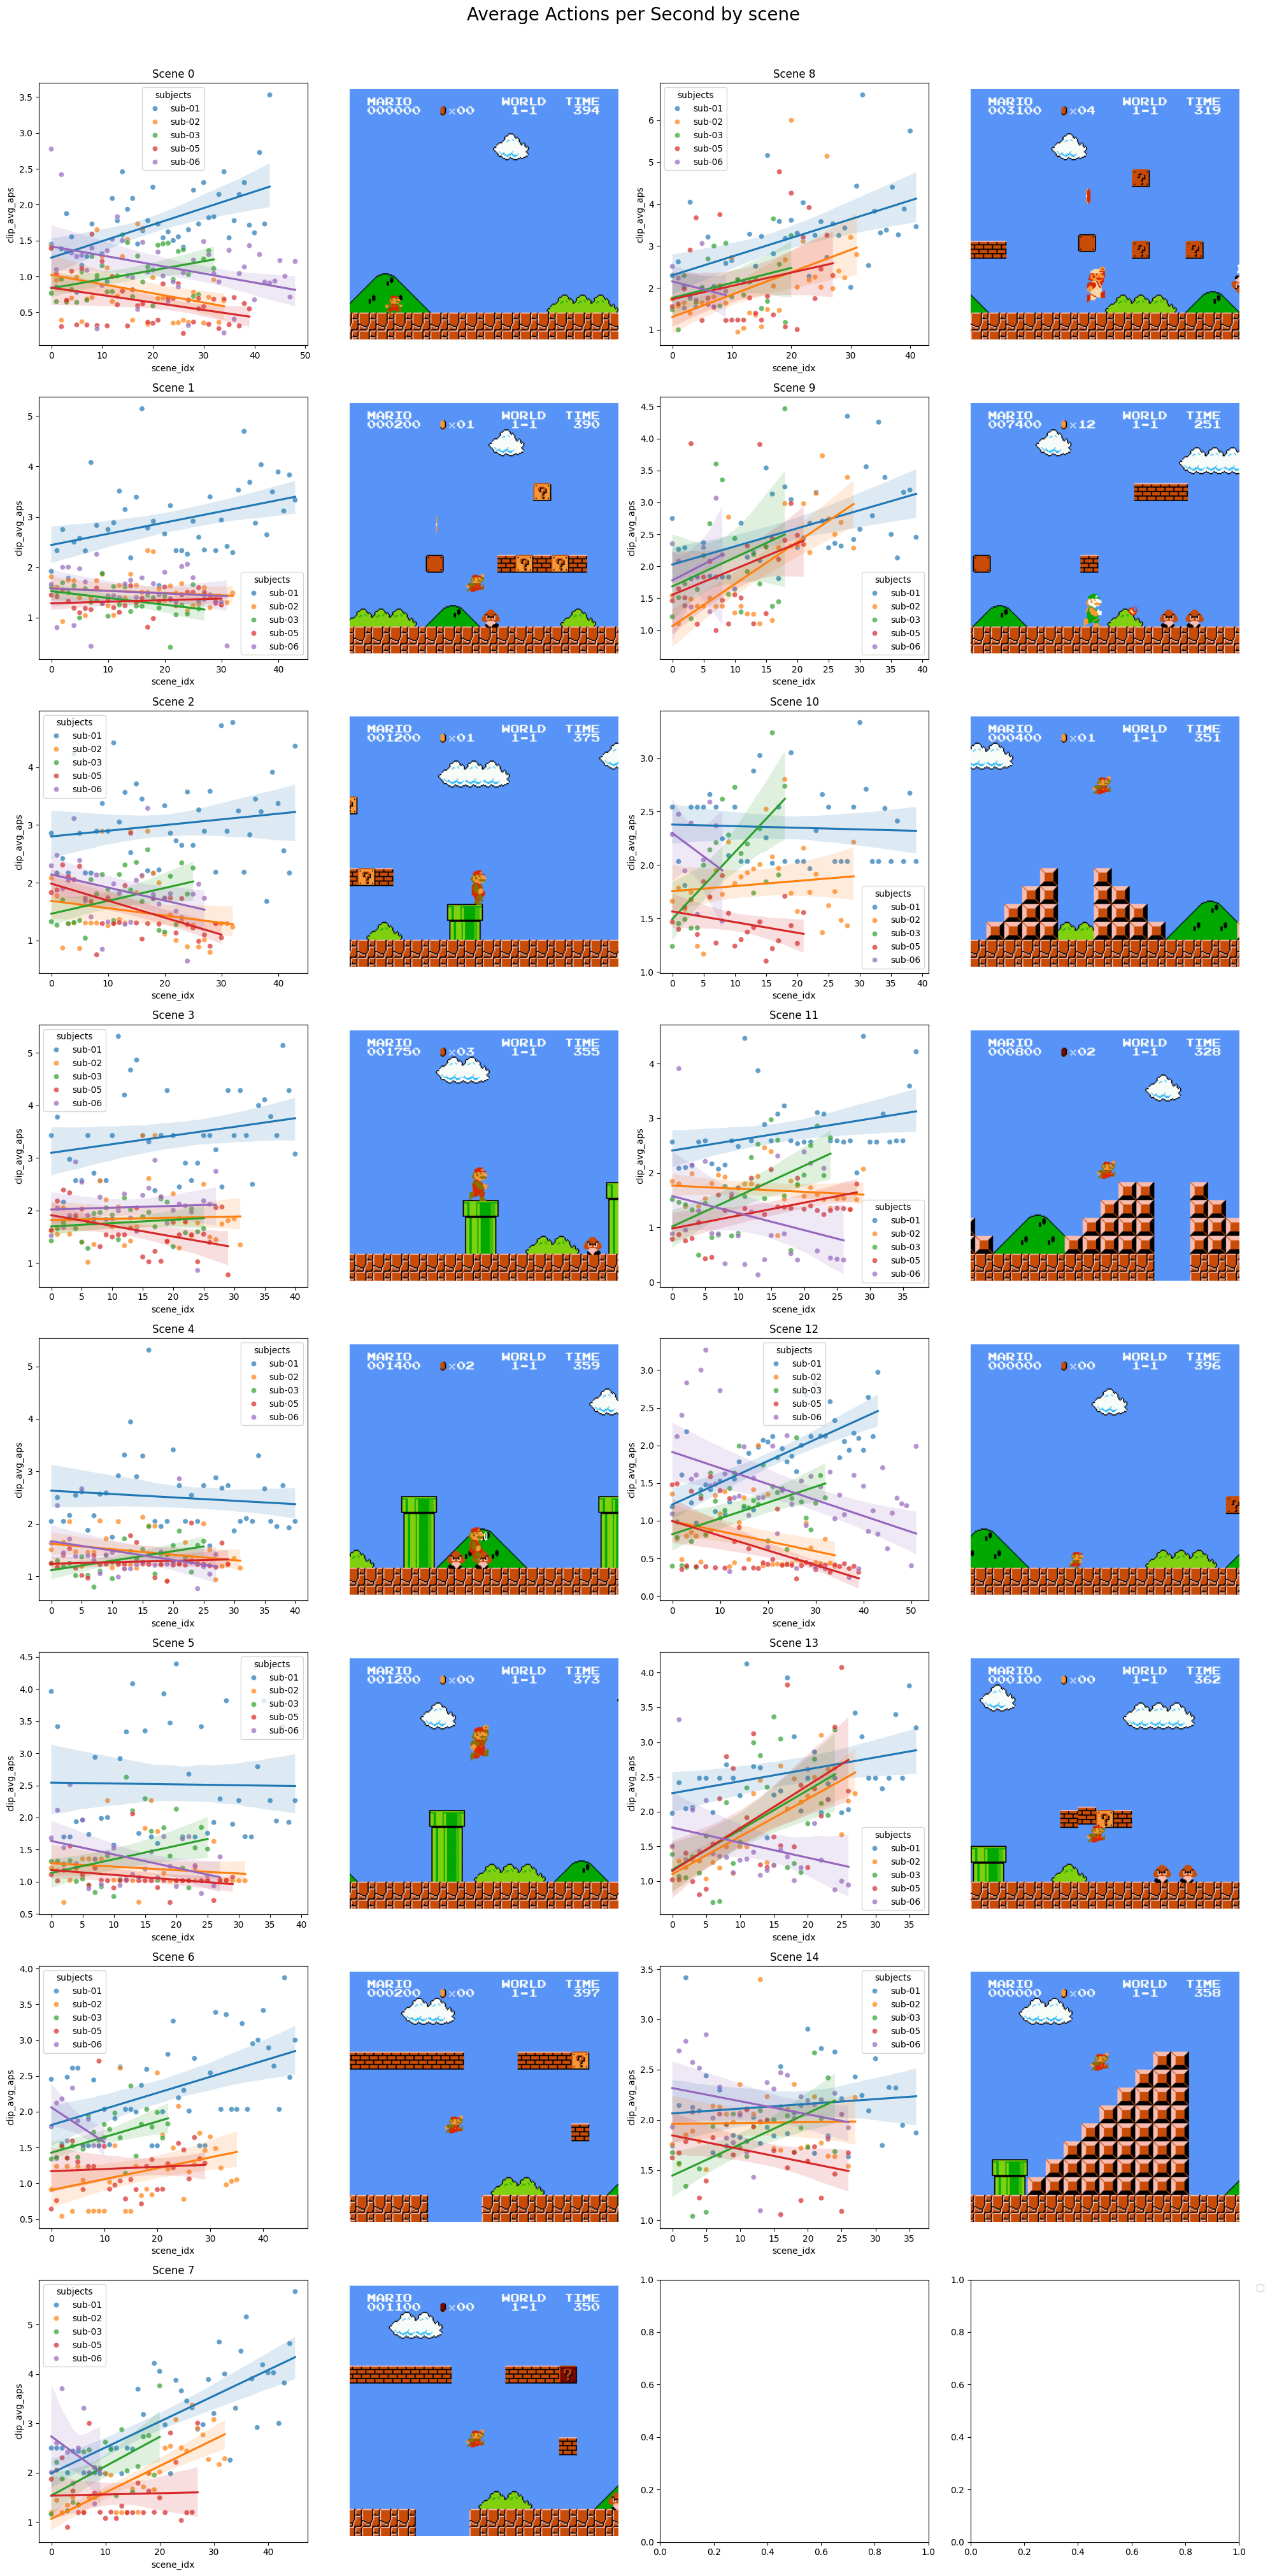

In [217]:
## Scene-wise analysis
performance_metric = 'clip_avg_aps'
fig, axs = plt.subplots(8, 4, figsize=(20, 40))
scenes_list = sorted([int(x) for x in allsubj_indexed_list['clip_scene'].unique()])

# Find all gif files in clips_folder
gif_files = [f for f in os.listdir(clips_fpath) if f.endswith('.gif')]
scene_files = {}
for scene in scenes_list:
    for file in gif_files:
        file_scene = int(file.split('_')[4].split('-')[1])
        if file_scene == scene:
            scene_files[scene] = file
            break


# Plotting
for idx_scene, scene in enumerate(scenes_list):
    scene_x_idx = 0 if scene < len(scenes_list)/2 else 2
    frame_x_idx = scene_x_idx + 1
    # Plot curves
    ax = axs[idx_scene%8, scene_x_idx]
    scene_df = allsubj_indexed_list[allsubj_indexed_list['clip_scene'] == str(scene)]
    ax = sns.scatterplot(x='scene_idx', y=performance_metric, data=scene_df, hue='subjects', ax=ax, alpha=0.7)
    ax.set_title(f'Scene {str(scene)}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # Add a regression line for each subject, keeping the same color as the subject from the lineplot
    for idx_subj, subj in enumerate(scene_df['subjects'].unique()):
        subj_df = scene_df[scene_df['subjects'] == subj]
        sns.regplot(x='scene_idx', y=performance_metric, data=subj_df, ax=ax, scatter=False, color=ax.get_lines()[idx_subj].get_c())
    # Plot frame
    ax_frame = axs[idx_scene%8, frame_x_idx]
    scene_file_path = op.join(clips_fpath, scene_files[scene])
    im = Image.open(scene_file_path)
    frames = ImageSequence.Iterator(im)
    for _ in range(50):
        frame = next(frames)
    ax_frame.imshow(frame)
    # remove axis
    ax_frame.axis('off')

if performance_metric == 'clip_duration':
    title = 'Clip Duration by scene'
elif performance_metric == 'clip_avg_aps':
    title = 'Average Actions per Second by scene'
plt.suptitle(title, fontsize=20, y=1.01)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


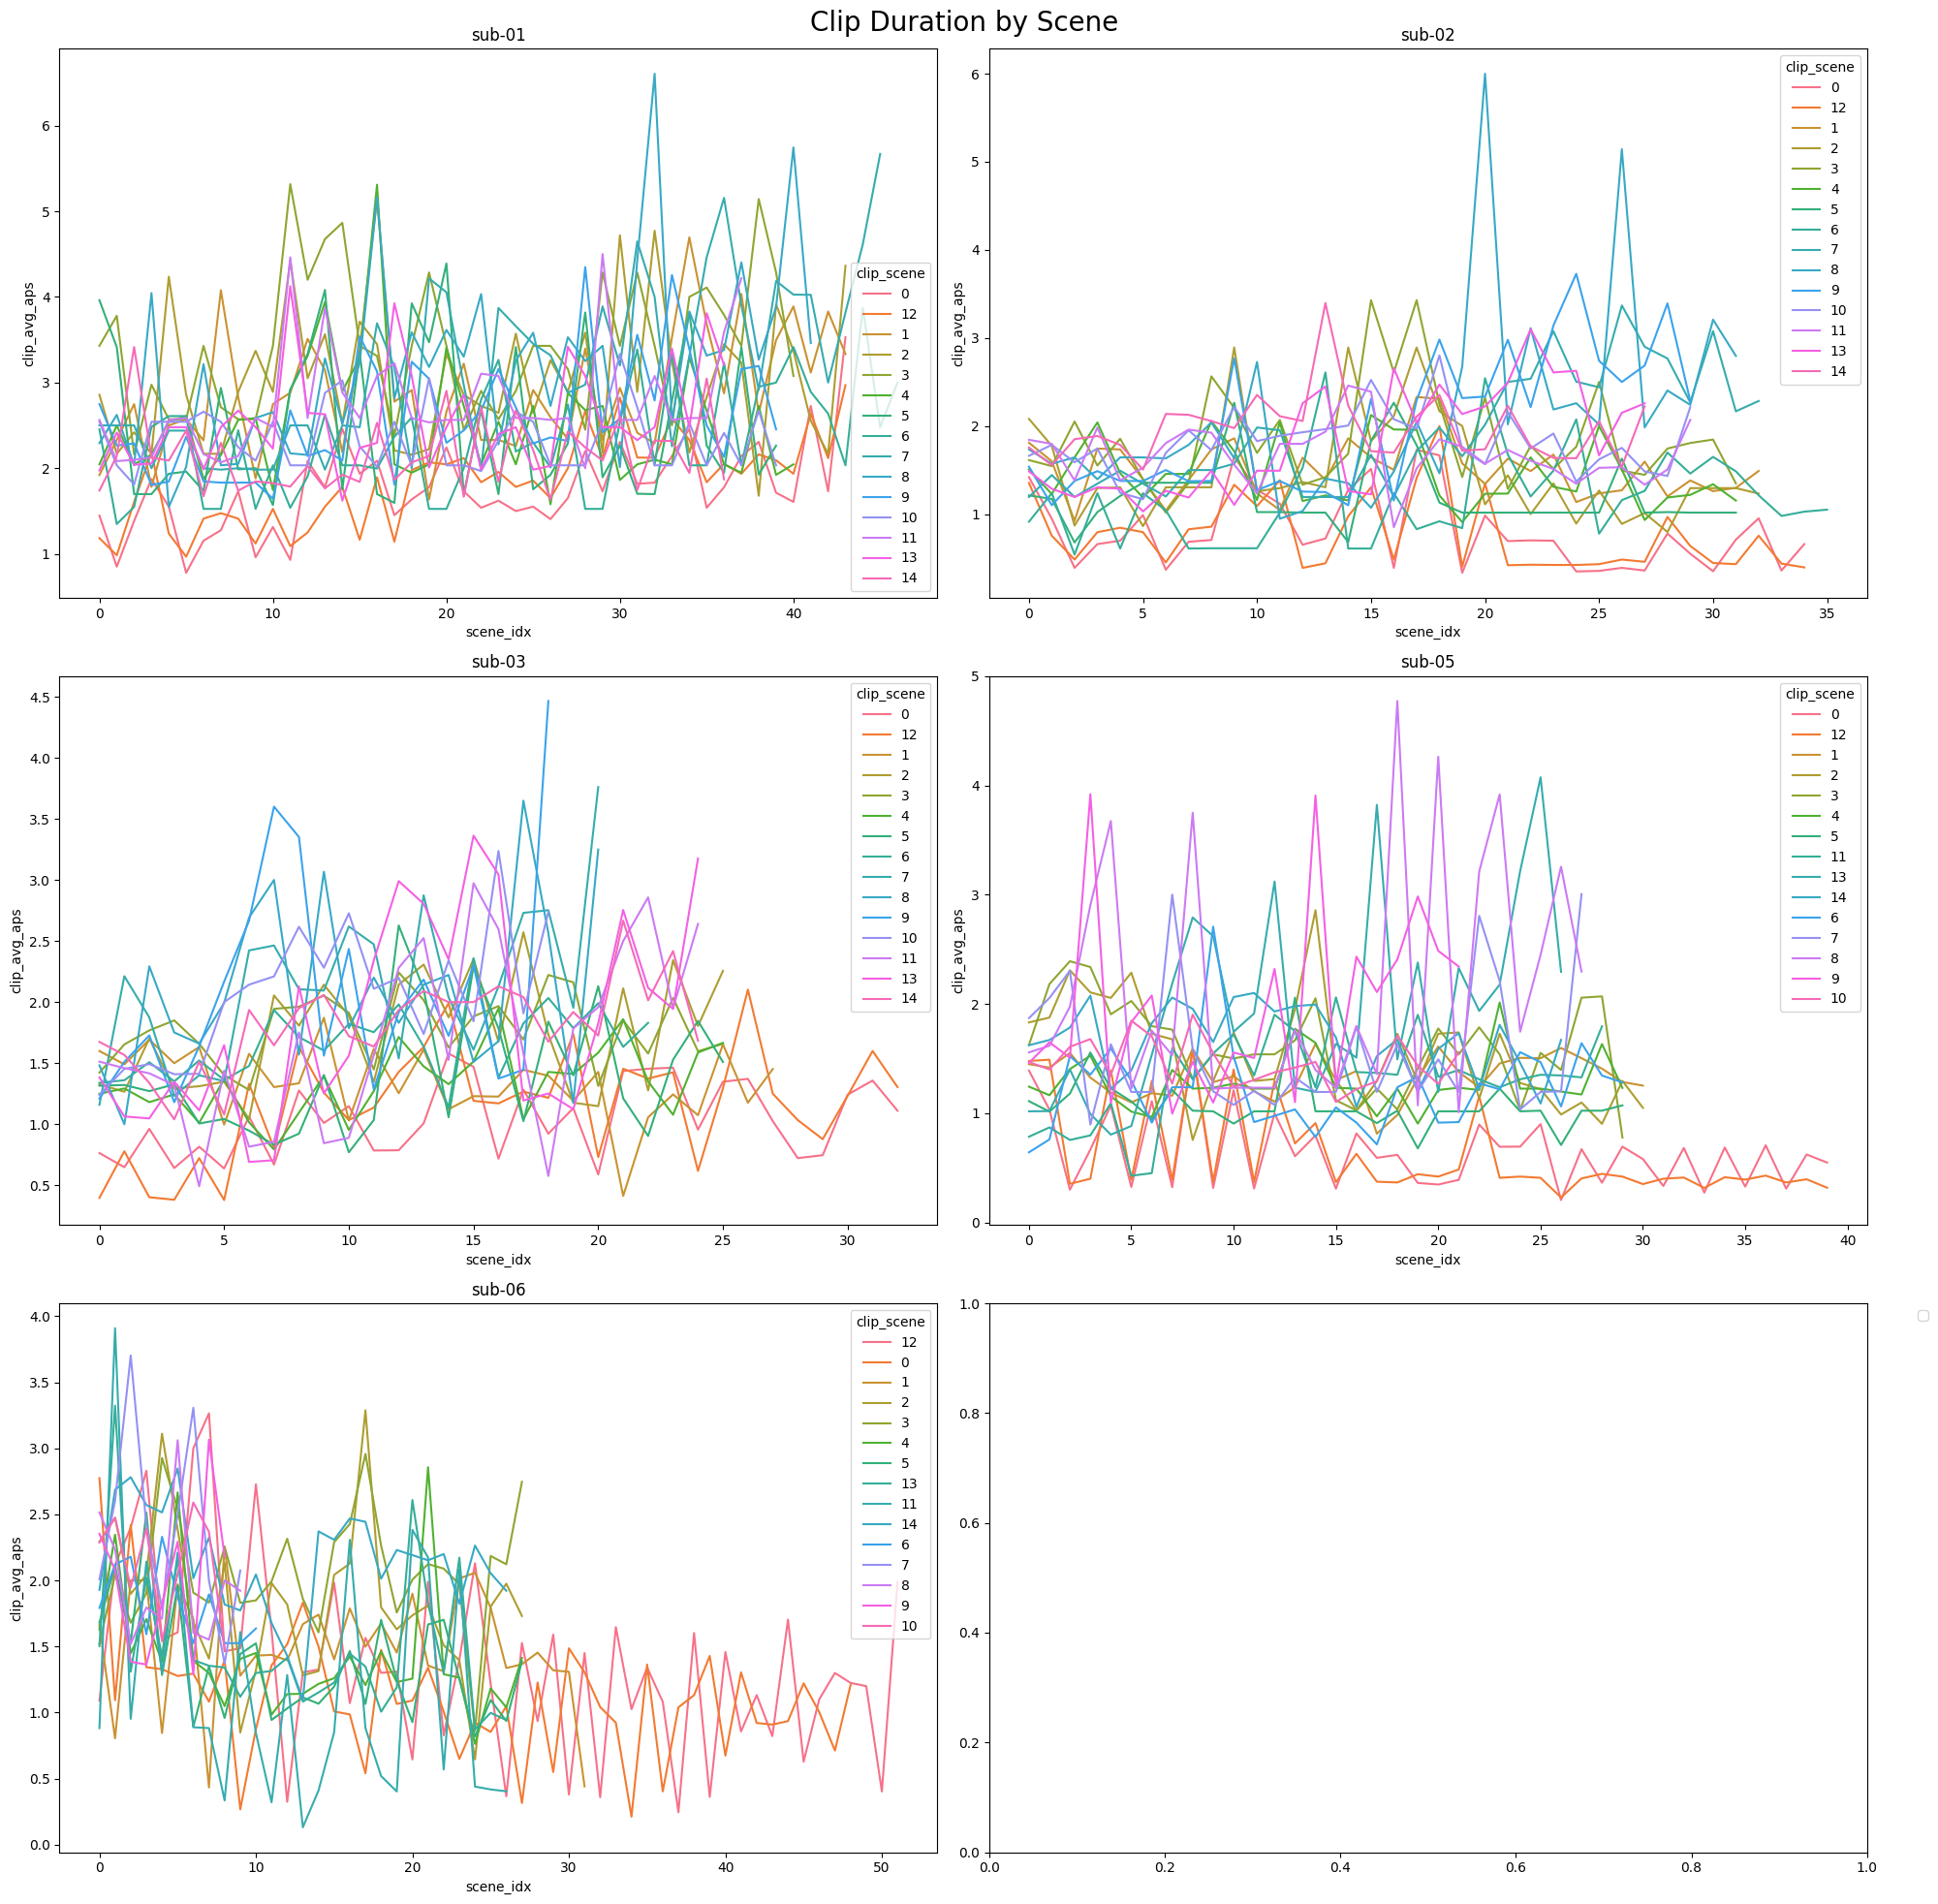

In [190]:
## Messy subject plot

# create a 2x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
flat_axs = axs.flatten()
for idx, subj in enumerate(allsubj_indexed_list['subjects'].unique()):
    ax = flat_axs[idx]
    sub_df = allsubj_indexed_list[allsubj_indexed_list['subjects'] == subj]
    ax = sns.lineplot(x='scene_idx', y='clip_avg_aps', data=sub_df, hue='clip_scene', ax=ax)
    ax.set_title(subj)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.suptitle('Clip Duration by Scene', fontsize=20)
plt.tight_layout()